# Learning to Drive in Adverse Weather Conditions

## Introduction & Setup

This project is designed to explore using Reinforcement learning to teach an autonomous agent to drive in adverse weather conditions.

### Setup

- The project will be performed using an autonomous drving simulator called CARLA.
- Python 3.8
- Anconda

[Project Github](https://github.com/rbuckley25/Tempestas)

### Image Segmentor

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import os
import numpy as np
from PIL import Image
from IPython import display
import carla

from torch.utils.data import DataLoader
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.utils import save_image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, weather, town, test=False , transform=None, target_transform=None):
        dirt = './Datasets/'+weather+'/'+town
        if test:
            dirt = dirt+'/test'
        
        self.sem_dir = dirt+'/Semantic'
        self.rgb_dir = dirt+'/RGB'
        self.transform = transform
        self.target_transform = target_transform
        self.names = os.listdir(self.rgb_dir)

    def __len__(self):
        return len(os.listdir(self.sem_dir))

    def __getitem__(self, idx): 
        img_path = os.path.join(self.rgb_dir, self.names[idx])
        image = read_image(img_path)
        label_name = self.names[idx].split('.')[0]+'.npy'
        label = np.load(os.path.join(self.sem_dir, label_name))
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [214]:
class PerceptionNet(nn.Module):

    def __init__(self):
        super(PerceptionNet,self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.conv5 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        
        self.conv6 = nn.Conv2d(512, 64, kernel_size=4, stride=1)
        
        self.conv7 = torch.nn.ConvTranspose2d(64,512, kernel_size =4, stride=1)
        self.bn6 = nn.BatchNorm2d(512)
        
        self.conv8 = torch.nn.ConvTranspose2d(512,256, kernel_size =4, stride=2, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        
        self.conv9 = torch.nn.ConvTranspose2d(256,128, kernel_size =4, stride=2, padding=1)
        self.bn8 = nn.BatchNorm2d(128)
        
        self.conv10 = torch.nn.ConvTranspose2d(128,64, kernel_size =4, stride=2, padding=1)
        self.bn9 = nn.BatchNorm2d(64)
        
        self.conv11 = torch.nn.ConvTranspose2d(64,32, kernel_size =4, stride=2, padding=1)
        self.bn10 = nn.BatchNorm2d(32)
        
        self.conv12 = torch.nn.ConvTranspose2d(32,23, kernel_size =4, stride=2,padding=1)
        
            
    def encode(self, x):
        x = F.leaky_relu(self.conv1(x),negative_slope=0.02)
        x = F.leaky_relu(self.bn2(self.conv2(x)),negative_slope=0.02)
        x = F.leaky_relu(self.bn3(self.conv3(x)),negative_slope=0.02)
        x = F.leaky_relu(self.bn4(self.conv4(x)),negative_slope=0.02)
        x = F.leaky_relu(self.bn5(self.conv5(x)),negative_slope=0.02)
        return self.conv6(x)
    
    def decode(self, x):
        x = F.leaky_relu(self.bn6(self.conv7(x)),negative_slope=0.02)
        x = F.leaky_relu(self.bn7(self.conv8(x)),negative_slope=0.02)
        x = F.leaky_relu(self.bn8(self.conv9(x)),negative_slope=0.02)
        x = F.leaky_relu(self.bn9(self.conv10(x)),negative_slope=0.02)
        x = F.leaky_relu(self.bn10(self.conv11(x)),negative_slope=0.02)
        return F.log_softmax(self.conv12(x),dim=1)
    
    def forward(self, x):
        x = x.to(device, dtype=torch.float32)
        latent = self.encode(x)
        out = self.decode(latent)
        return out, latent

In [215]:
model = PerceptionNet()
model.to(device)

PerceptionNet(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(512, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv7): ConvTranspose2d(64, 512, kernel_size=(4, 4), stride=(1, 1))
  (bn6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv8): Con

In [216]:
def initalize_weights(layer):
    if isinstance(layer, torch.nn.Conv2d) or isinstance(layer,torch.nn.ConvTranspose2d):
        nn.init.kaiming_uniform_(layer.weight.data,nonlinearity='relu')

In [217]:
model.apply(initalize_weights)

PerceptionNet(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(512, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv7): ConvTranspose2d(64, 512, kernel_size=(4, 4), stride=(1, 1))
  (bn6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv8): Con

In [218]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Reference: https://github.com/pytorch/examples/blob/master/vae/main.py

In [219]:
train_data = CustomImageDataset('ClearNoon','Town04',test=False)
test_data = CustomImageDataset('ClearNoon','Town04',test=True)

In [220]:
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(test_data, batch_size=100, shuffle=True)

In [221]:
torch.cuda.empty_cache()

In [222]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        rgb = data[0]
        preds = data[1]
        batch_size = preds.shape[0]
        preds = F.one_hot(preds.to(torch.int64))
        preds = preds.permute(0,3,4,1,2)
        preds = preds.reshape(batch_size,23,128,128)
        preds = preds.to(device,dtype=torch.float32)
        optimizer.zero_grad()
        #dont need latent space output while training
        y_batch,_ = model(rgb)
        loss = loss_fn(y_batch, preds)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data[0]), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data[0])))
    avg_loss = train_loss / len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, avg_loss))
    return avg_loss
    
    


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            rgb = data[0]
            preds = data[1]
            batch_size = preds.shape[0]
            preds = F.one_hot(preds.to(torch.int64))
            preds = preds.reshape(batch_size,23,128,128)
            preds = preds.to(device,dtype=torch.float32)
            y_batch,_ = model(rgb)
            test_loss += loss_fn(y_batch,preds).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


for epoch in range(1, 5 + 1):
    smallest_loss = 1000
    avg_loss = train(epoch)
    if avg_loss < smallest_loss:
        torch.save(model.state_dict(), './AE_params/model_3.best')
    test(epoch)
   

Train Epoch: 1 [0/50501 (0%)]	Loss: 0.031996
Train Epoch: 1 [1000/50501 (2%)]	Loss: 0.020326
Train Epoch: 1 [2000/50501 (4%)]	Loss: 0.013978
Train Epoch: 1 [3000/50501 (6%)]	Loss: 0.009540
Train Epoch: 1 [4000/50501 (8%)]	Loss: 0.007816
Train Epoch: 1 [5000/50501 (10%)]	Loss: 0.007399
Train Epoch: 1 [6000/50501 (12%)]	Loss: 0.006632
Train Epoch: 1 [7000/50501 (14%)]	Loss: 0.005632
Train Epoch: 1 [8000/50501 (16%)]	Loss: 0.005229
Train Epoch: 1 [9000/50501 (18%)]	Loss: 0.005106
Train Epoch: 1 [10000/50501 (20%)]	Loss: 0.005260
Train Epoch: 1 [11000/50501 (22%)]	Loss: 0.005051
Train Epoch: 1 [12000/50501 (24%)]	Loss: 0.004659
Train Epoch: 1 [13000/50501 (26%)]	Loss: 0.004736
Train Epoch: 1 [14000/50501 (28%)]	Loss: 0.004065
Train Epoch: 1 [15000/50501 (30%)]	Loss: 0.004464
Train Epoch: 1 [16000/50501 (32%)]	Loss: 0.003738
Train Epoch: 1 [17000/50501 (34%)]	Loss: 0.003898
Train Epoch: 1 [18000/50501 (36%)]	Loss: 0.003418
Train Epoch: 1 [19000/50501 (38%)]	Loss: 0.003611
Train Epoch: 1 [20

Train Epoch: 4 [9000/50501 (18%)]	Loss: 0.001495
Train Epoch: 4 [10000/50501 (20%)]	Loss: 0.001567
Train Epoch: 4 [11000/50501 (22%)]	Loss: 0.001541
Train Epoch: 4 [12000/50501 (24%)]	Loss: 0.001577
Train Epoch: 4 [13000/50501 (26%)]	Loss: 0.001516
Train Epoch: 4 [14000/50501 (28%)]	Loss: 0.001488
Train Epoch: 4 [15000/50501 (30%)]	Loss: 0.001718
Train Epoch: 4 [16000/50501 (32%)]	Loss: 0.001428
Train Epoch: 4 [17000/50501 (34%)]	Loss: 0.001445
Train Epoch: 4 [18000/50501 (36%)]	Loss: 0.001527
Train Epoch: 4 [19000/50501 (38%)]	Loss: 0.001591
Train Epoch: 4 [20000/50501 (40%)]	Loss: 0.001647
Train Epoch: 4 [21000/50501 (42%)]	Loss: 0.001482
Train Epoch: 4 [22000/50501 (43%)]	Loss: 0.001495
Train Epoch: 4 [23000/50501 (45%)]	Loss: 0.001532
Train Epoch: 4 [24000/50501 (47%)]	Loss: 0.001525
Train Epoch: 4 [25000/50501 (49%)]	Loss: 0.001365
Train Epoch: 4 [26000/50501 (51%)]	Loss: 0.001492
Train Epoch: 4 [27000/50501 (53%)]	Loss: 0.001453
Train Epoch: 4 [28000/50501 (55%)]	Loss: 0.001491
T

In [233]:
torch.cuda.empty_cache()

In [119]:
model.load_state_dict(torch.load('./AE_params/model_3.best'))
model.eval()

PerceptionNet(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(512, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv7): ConvTranspose2d(64, 512, kernel_size=(4, 4), stride=(1, 1))
  (bn6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv8): Con

In [232]:
 with torch.no_grad():
        sample_index = random.randint(0,test_data.__len__()-1)
        test_item = train_data.__getitem__(sample_index)
        sample = test_item[0].to(device)
        actual = test_item[1]
        sample,latent_space = model(sample.reshape(1,3,128,128))
        sample = sample.cpu().argmax(dim=1)
        print(latent_space.shape)
        #save_image(sample.view(64, 1, 28, 28),
                   #'results/sample_' + str(epoch) + '.png')

torch.Size([1, 64, 1, 1])


In [224]:
sample[0][10]

tensor([13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13])

In [188]:
test_item[0]

tensor([[[131, 131, 132,  ..., 232, 232, 232],
         [131, 131, 132,  ..., 232, 232, 232],
         [132, 132, 133,  ..., 231, 231, 231],
         ...,
         [107, 102, 100,  ..., 116, 104,  85],
         [106, 105, 109,  ..., 105, 111, 122],
         [101, 110, 112,  ..., 124, 123, 112]],

        [[148, 148, 149,  ..., 232, 232, 232],
         [148, 148, 149,  ..., 232, 232, 232],
         [149, 149, 150,  ..., 231, 231, 231],
         ...,
         [ 68,  63,  61,  ...,  77,  65,  44],
         [ 65,  64,  68,  ...,  62,  68,  79],
         [ 60,  69,  71,  ...,  81,  78,  67]],

        [[176, 176, 177,  ..., 234, 234, 234],
         [176, 176, 177,  ..., 234, 234, 234],
         [177, 177, 178,  ..., 233, 233, 233],
         ...,
         [ 73,  68,  66,  ...,  82,  70,  50],
         [ 71,  70,  74,  ...,  69,  75,  86],
         [ 66,  75,  77,  ...,  88,  85,  74]]], dtype=torch.uint8)

In [189]:
test_item[0].reshape(1,3,128,128)

tensor([[[[131, 131, 132,  ..., 232, 232, 232],
          [131, 131, 132,  ..., 232, 232, 232],
          [132, 132, 133,  ..., 231, 231, 231],
          ...,
          [107, 102, 100,  ..., 116, 104,  85],
          [106, 105, 109,  ..., 105, 111, 122],
          [101, 110, 112,  ..., 124, 123, 112]],

         [[148, 148, 149,  ..., 232, 232, 232],
          [148, 148, 149,  ..., 232, 232, 232],
          [149, 149, 150,  ..., 231, 231, 231],
          ...,
          [ 68,  63,  61,  ...,  77,  65,  44],
          [ 65,  64,  68,  ...,  62,  68,  79],
          [ 60,  69,  71,  ...,  81,  78,  67]],

         [[176, 176, 177,  ..., 234, 234, 234],
          [176, 176, 177,  ..., 234, 234, 234],
          [177, 177, 178,  ..., 233, 233, 233],
          ...,
          [ 73,  68,  66,  ...,  82,  70,  50],
          [ 71,  70,  74,  ...,  69,  75,  86],
          [ 66,  75,  77,  ...,  88,  85,  74]]]], dtype=torch.uint8)

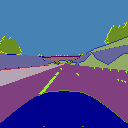

In [179]:
data = train_data.__getitem__(1000)
sem = replace(data[1])
Image.fromarray(sem.reshape(128,128,3))

In [207]:
im = Image.fromarray(data[0].permute((1,2,0)).numpy(), 'RGB')

In [208]:
im.show()

In [121]:
tag_convert_dict = {0:[0,0,0],
                   1:[70,70,70],
                   2:[100,40,40],
                   3:[55,90,80],
                   4:[220,20,60],
                   5:[153,153,153],
                   6:[157,234,50],
                   7:[128,64,128],
                   8:[244,35,232],
                   9:[107,142,35],
                   10:[0,0,142],
                   11:[102,102,156],
                   12:[220,220,0],
                   13:[70,130,180],
                   14:[81,0,81],
                   15:[150,100,100],
                   16:[230,150,140],
                   17:[180,165,180],
                   18:[250,170,30],
                   19:[110,190,160],
                   20:[170,120,50],
                   21:[45,60,150],
                   22:[145,170,100],
                  }

In [225]:
def replace(a):
    a = a.reshape(128,128)
    pic = np.zeros((128,128,3),dtype='uint8')
    for x, y in np.ndindex(a.shape):
        value = a[x,y]
        RGB_values = tag_convert_dict[value]
        pic[x,y,0] = RGB_values[0]
        pic[x,y,1] = RGB_values[1]
        pic[x,y,2] = RGB_values[2]
    return pic

In [123]:
sample[:,0,:]

tensor([[18, 18, 15,  7,  4,  1,  9, 12,  3,  9,  9, 20,  3,  0, 14,  5, 12, 16,
         13,  5,  2, 10,  7, 18, 18, 15,  7,  4,  1,  9, 12, 10,  9,  9, 20,  3,
          0, 14,  5, 11, 16, 13,  5,  2, 10,  7, 18, 18, 15, 21,  4,  1,  9, 12,
          9,  9,  9, 20,  3,  0, 14,  5, 11, 16,  8,  5,  2, 10,  7, 18, 18, 15,
         21,  4,  1,  9, 12, 14,  9,  9,  6,  3, 11,  8,  5, 12, 16,  8,  5,  2,
         10,  7, 18, 18, 15,  7,  4,  1,  9, 12,  3, 11,  9,  6,  3,  0, 14,  5,
         12, 16, 22, 19,  2, 10,  7, 18, 18, 15,  7,  4,  1,  9, 12, 11,  9,  9,
         20,  3]])

In [226]:
pic = replace(sample.numpy())

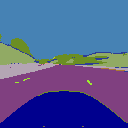

In [227]:
Image.fromarray(pic,'RGB')

In [93]:
im.show()

In [34]:
out = func(sample.numpy())

ValueError: setting an array element with a sequence.

In [30]:
out

array([[[20, 32, 20, ...,  8, 20,  8],
        [30, 14, 30, ...,  6, 12,  6],
        [14,  8, 40, ...,  8, 32,  8],
        ...,
        [ 6,  6, 30, ..., 16, 12,  4],
        [ 8, 32,  8, ..., 32,  8,  8],
        [14, 14,  6, ..., 14, 30, 22]]])

In [150]:
im = Image.open('./Datasets/ClearNoon/Town03/RGB/Tue, 01 Feb 2022 14:40:47.jpeg')

In [151]:
im.show()

In [141]:
t_im = read_image('./Datasets/ClearNoon/Town03/RGB/Tue, 01 Feb 2022 14:40:47.jpeg')

In [154]:
new_t = t_im.reshape(128,128,3)

In [157]:
def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = T.ToPILImage()(img.to('cpu'))
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

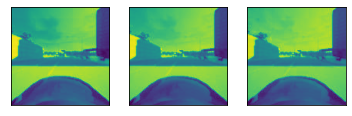

In [158]:
show(t_im)

In [147]:
import matplotlib.pyplot as plt
import torchvision.transforms as T